In [18]:
#-*- coding: utf-8 -*-
import pickle
import os
import gc

def containlogfile(folder):
    ''' Does the folder contain log file?
    Args:
        folder: str
    '''
    
    for e in os.listdir(folder):
        if '.pkl' in e:
            return True        
    return False

data_path = '../TinyOS-Benchmark/preprocessed-dataset/'
paths_data = {}
paths = list(os.walk(data_path))
for i in range(len(paths)):
    #if i > 8: break
    print('{:2}/{:2}: {}'.format(i, len(paths)-1, paths[i][0]))
    if containlogfile(paths[i][0]) and paths[i][0] not in paths_data:
        paths_data[paths[i][0]] = []
    for e2 in paths[i][2]:
        fn = os.path.join(paths[i][0], e2)
        with open(fn, 'rb') as f:
            paths_data[paths[i][0]] += pickle.load(f)
            

    
## covert data format of fre to tran
temp_paths_data = {k: [] for k in paths_data.keys()}
idx = 0
for k in paths_data.keys():
    idx += 1
    print('Coverting {:2}: {}'.format(idx, k))
    for i in range(len(paths_data[k])-1):
        temp_paths_data[k].append((paths_data[k][i][0], paths_data[k][i][1]+'-'+paths_data[k][i+1][1]))
paths_data = temp_paths_data            

def most_tasks(ls, num=5):
    ''' shoot tasks make up the majority in the logs
    Args:
        ls: list, logs look [(timestamp, taskid) ...]
        num: int, the top of task
    Retval:
        ([(taskid, number, precent) ... num], allprecent, num)
        allprecent is the sum of each prcent in the first item precents  
        num is the number of tasks, len(ls) yet.
    '''
    count = {}
    for e in ls:
        if e[1] in count:
            count[e[1]] += 1
        else:
            count[e[1]] = 1

    count = list(map(lambda k: (k, count[k]), count.keys()))
    count = sorted(count, key=lambda e: e[1], reverse=True)
    #count = list(map(lambda e: (e[0], e[1],  # using round to calculate the precent of tasks
    #                 round(float(e[1]) / len(ls), 2)), count))
    # no round() function
    count = list(map(lambda e: (e[0], e[1], 
                    float(e[1]) / len(ls)), count))  
    
    return count[:num], sum(map(lambda e: e[2], count[:num])), len(ls)    
    

 0/49: ../TinyOS-Benchmark/preprocessed-dataset/
 1/49: ../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds
 2/49: ../TinyOS-Benchmark/preprocessed-dataset/TCPEcho
 3/49: ../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope
 4/49: ../TinyOS-Benchmark/preprocessed-dataset/tests
 5/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLpl
 6/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress
 7/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed
 8/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLedSingle
 9/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/BlinkLed
10/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLed
11/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/LedColor
12/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420
13/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/TestAcks
14/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/cc2420/LplBroadcastCountToLeds
15/49: ../T

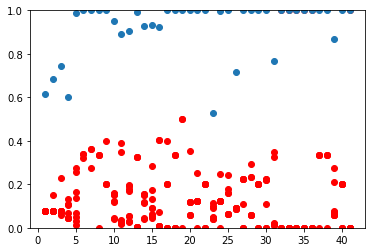

In [19]:
###################### 2d ######################################
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
top_task_num = 8
y = []
idx = 1 #
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    for e in map(lambda e: e[2], retval[0]):
        plt.plot([idx], [e], marker='o', color='r')
    idx += 1
    y.append(sum(map(lambda e: e[2], retval[0])))
plt.ylim(0, 1)
plt.plot(list(range(1, len(y) + 1)), y, marker='o', linestyle=' ')

plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)
############ end of 2d ###########

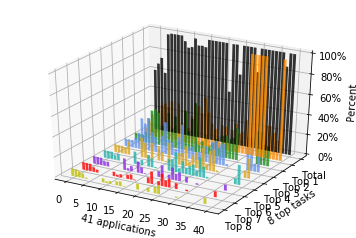

In [20]:

###################### 3d ######################################
colors = ['darkorange', 'forestgreen', 'cornflowerblue', 'goldenrod', 'lightseagreen', 'blueviolet', 'red',
         'y', 'teal', 'fuchsia', 'orangered', 'lawngreen', 'hotpink']

prob = [[] for i in range(top_task_num)]
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    #temp = list(map(lambda e: e[2], retval[0]))
    for i in range(top_task_num):
        if i >= len(retval[0]):
            prob[i].append(0.0)
        else:
            prob[i].append(retval[0][i][2])
plus_prob = []    

# Add up all the values.
for i in range(len(prob[0])):
    plus_prob.append(sum(map(lambda e: e[i], prob)))
prob.insert(0, plus_prob)

fig = plt.figure(1)
ax = fig.gca(projection='3d')
idx = 0
for c, z in zip(['k'] + [colors[i] for i in range(top_task_num)], reversed([i * 10 for i in range(top_task_num + 1)])):
    xs = np.arange(len(prob[0]))
    ys = prob[idx]
    idx += 1
    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)
    
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_yticklabels(['Top {}'.format(top_task_num-i) for i in range(top_task_num)] + ['Total'])
ax.set_zticklabels(['{}%'.format(i*20) for i in range(6)])
ax.set_xlabel('{} applications'.format(len(prob[0])))
ax.set_ylabel('{} top tasks'.format(top_task_num))
ax.set_zlabel('Percent')
plt.savefig('feature-by-frequency-3d.png')
plt.show()
plt.close(1)
############ end of 3d ###########

In [2]:
## test
import xlsxwriter,xlrd
import sys,os.path

from xlrd.timemachine import xrange

fname = 'tables.xlsx'
if not os.path.isfile(fname):
    print ('do not exist this file')
    sys.exit()
data = xlrd.open_workbook(fname)            # 打开fname文件
data.sheet_names()                          # 获取xls文件中所有sheet的名称
table = data.sheet_by_index(0)              # 通过索引获取xls文件第0个sheet
nrows = table.nrows                         # 获取table工作表总行数
ncols = table.ncols                         # 获取table工作表总列数
workbook = xlsxwriter.Workbook('zm6.xls')  #创建一个excel文件
# worksheet = workbook.add_worksheet()        #创建一个工作表对象


print(data.sheet_names())

for a, val in enumerate(data.sheet_names()):
    worksheet = workbook.add_worksheet(val)
    for i in xrange( data.sheet_by_name(val).nrows):
        for j in xrange(data.sheet_by_name(val).ncols):
            cell_value = table.cell_value(i, j, )  # 获取第i行中第j列的值
            worksheet.write(i, j, cell_value)  # 把获取到的值写入文件对应的行列
workbook.close()

do not exist this file


SystemExit: 

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
#coding=utf-8  
import xlwt  
import xlrd  
try:  
    # 创建excel文件  
    filename=xlwt.Workbook()  

    # 给工作表命名，test  
    sheet=filename.add_sheet("tab1")  
    # 写入内容，第4行第3列写入‘张三丰’  
    hello=u'张三丰'  
    sheet.write(3,2,hello)  
    # 指定存储路径，如果当前路径存在同名文件，会覆盖掉同名文件  
    filename.save("./tables1.xlsx")  

except Exception as e:  
    print(str(e))  